In [75]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [76]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


# Chargement des données

In [77]:
data = pd.read_csv("conversion_data.csv")

In [78]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [79]:
data.shape

(316200, 6)

In [80]:
data.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


## Visualisation des données

## Variables continues

In [81]:
data.isnull().any()

country                False
age                    False
new_user               False
source                 False
total_pages_visited    False
converted              False
dtype: bool

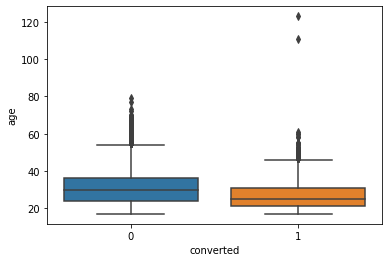

In [82]:
sns.boxplot('converted', 'age', data=data)

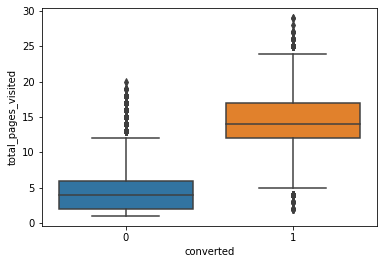

In [83]:
sns.boxplot('converted', 'total_pages_visited', data=data)

## Variables continues

In [84]:
data["country"].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

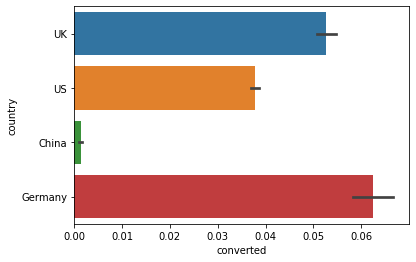

In [85]:
sns.barplot(x='converted', y='country', data=data)

In [86]:
data["source"].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

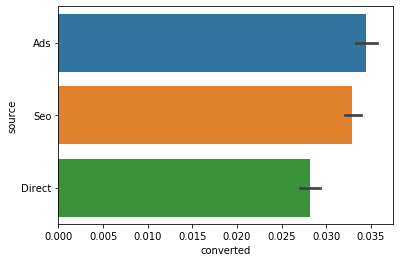

In [87]:
sns.barplot(x='converted', y='source', data=data)

## Tests statistiques

### Test de Student entre total_pages_visited et converted

In [88]:
p = ttest_ind(data["total_pages_visited"], data["converted"])
p

Ttest_indResult(statistic=813.5672952052461, pvalue=0.0)

In [89]:
p = ttest_ind(data["age"], data["converted"])
p

Ttest_indResult(statistic=2075.4709533942146, pvalue=0.0)

### Test du Chi-2

In [90]:
X = "country"
Y = "converted"
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)

In [91]:
chi2, p, dof, exp = chi2_contingency(cont)

In [92]:
p

0.0

In [93]:
X = "source"
Y = "converted"
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)

In [94]:
chi2, p, dof, exp = chi2_contingency(cont)

In [95]:
p

1.2160321383469431e-12

In [96]:
X = "new_user"
Y = "converted"
cont = data[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)
chi2, p, dof, exp = chi2_contingency(cont)
p

0.0

### Matrice de corrélation

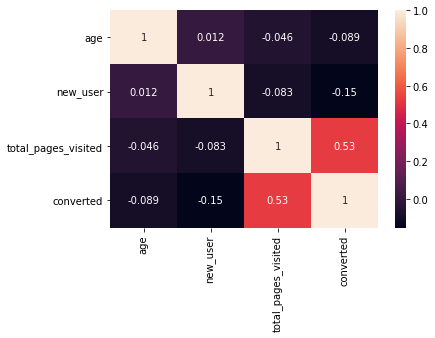

In [97]:
sns.heatmap(data.corr(), annot=True)

## Analyse en composantes principales

In [98]:
data2 = pd.get_dummies(data, columns=['country','source'], drop_first=True)

In [99]:
X = data2.loc[:,['age','new_user','total_pages_visited','country_Germany', 'country_UK','country_US','source_Direct','source_Seo']]

In [100]:
y = data2.loc[:,["converted"]]

In [101]:
sc = StandardScaler()
Z = sc.fit_transform(X)

In [102]:
print(np.std(Z,axis=0))

[1. 1. 1. 1. 1. 1. 1. 1.]


In [103]:
acp = PCA(svd_solver='full')
print(acp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)


In [104]:
#calculs
coord = acp.fit_transform(Z)
#nombre de composantes calculées
n=acp.n_components_
n

8

In [105]:
#variance expliquée
print(acp.explained_variance_)

[1.53512649 1.50682446 1.10191461 1.06858478 0.98952905 0.91098722
 0.46536594 0.42169275]


In [106]:
#valeur corrigée
eigval = (n-1)/n*acp.explained_variance_
print(eigval)

[1.34323568 1.3184714  0.96417529 0.93501168 0.86583791 0.79711382
 0.4071952  0.36898116]


In [107]:
#proportion de variance expliquée
print(acp.explained_variance_ratio_)

[0.1918902  0.18835246 0.13773889 0.13357267 0.12369074 0.11387304
 0.05817056 0.05271143]


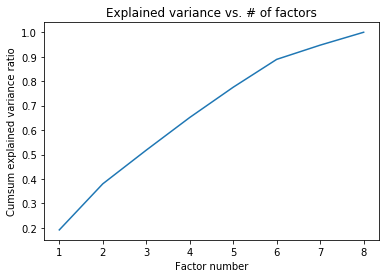

In [108]:
#cumul de variance expliquée
plt.plot(np.arange(1,n+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [109]:
#le champ components_ de l'objet ACP
print(acp.components_)

[[-7.87945135e-04  6.82429783e-03 -1.88685134e-02 -3.17145005e-02
  -6.63162519e-02  7.80562296e-02  7.03000454e-01 -7.02773591e-01]
 [-1.00450787e-02  1.87493354e-03  1.38558585e-02  2.21595704e-01
   6.48537167e-01 -7.20085100e-01  7.52645784e-02 -7.62310600e-02]
 [-3.85115640e-01 -6.07443428e-01  6.85914215e-01  1.02020329e-01
  -1.82663101e-02  3.43521927e-02  7.28940634e-03 -1.56557084e-02]
 [ 4.62151863e-02  6.87383279e-02 -5.22494717e-02  8.93819312e-01
  -4.24149578e-01 -1.07338436e-01  1.97223773e-03 -8.24223726e-03]
 [ 8.76295824e-01 -4.76457687e-01  7.02887089e-02  8.59129878e-05
   1.03399758e-02 -1.86224495e-03  5.94198612e-03 -2.73883321e-03]
 [ 2.85539502e-01  6.31778728e-01  7.19222341e-01 -4.70771041e-03
   2.63206673e-02  3.50123928e-02  2.01980954e-03 -9.85740315e-03]
 [ 2.42708587e-03 -1.41796304e-03 -6.77404449e-03 -1.00009855e-02
  -7.46980957e-03 -9.03370034e-03 -7.07048801e-01 -7.06958824e-01]
 [-3.93791871e-03 -8.89597498e-03  6.30595784e-02 -3.74761570e-01
  -

In [110]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [111]:
#corrélation des variables avec les axes
corvar = np.zeros((n,n))
for k in range(n):
 corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[-9.13213007e-04 -1.15342325e-02 -3.78154396e-01  4.46882374e-02
   8.15396873e-01  2.54933182e-01  1.54876835e-03 -2.39204222e-03]
 [ 7.90922777e-03  2.15288701e-03 -5.96463449e-01  6.64672149e-02
  -4.43345840e-01  5.64059826e-01 -9.04828422e-04 -5.40375495e-03]
 [-2.18682382e-02  1.59099494e-02  6.73515820e-01 -5.05231501e-02
   6.54039332e-02  6.42130560e-01 -4.32264298e-03  3.83047962e-02]
 [-3.67564860e-02  2.54446625e-01  1.00176238e-01  8.64287539e-01
   7.99423890e-05 -4.20310180e-03 -6.38181365e-03 -2.27644490e-01]
 [-7.68592395e-02  7.44680922e-01 -1.79361334e-02 -4.10135684e-01
   9.62139007e-03  2.34994158e-02 -4.76662354e-03 -3.81241722e-01]
 [ 9.04656440e-02 -8.26835629e-01  3.37312520e-02 -1.03791976e-01
  -1.73282659e-03  3.12594953e-02 -5.76457114e-03 -4.12598615e-01]
 [ 8.14763782e-01  8.64223340e-02  7.15764505e-03  1.90707503e-03
   5.52904256e-03  1.80331082e-03 -4.51180907e-01  6.40513856e-03]
 [-8.14500852e-01 -8.75320936e-02 -1.53727201e-02 -7.96991390e-03
  -

In [112]:
X.index[2]

2

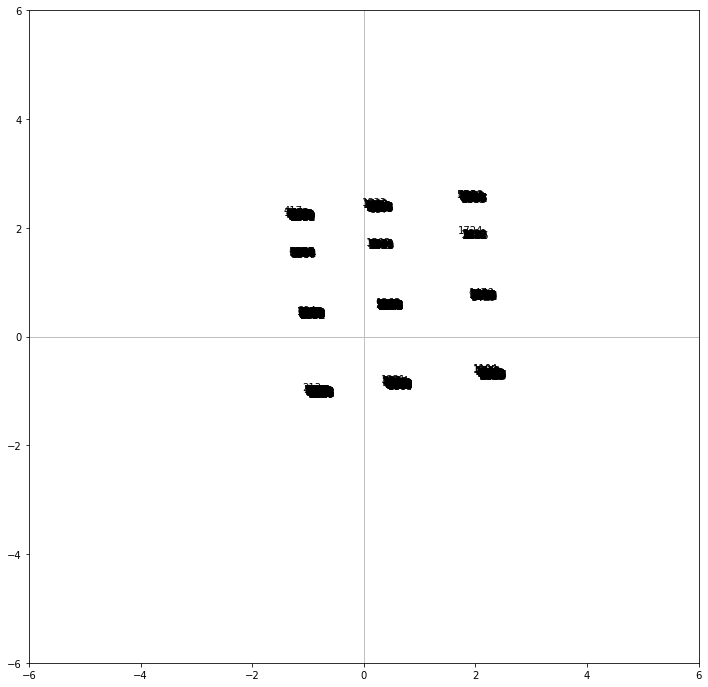

In [113]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
#même limites en abscisse
axes.set_ylim(-6,6)
#et en ordonnée #placement des étiquettes des observations
#On met uniquement 2000 individus pour limiter les temps de calcul
for i in range(2000):
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]))
#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

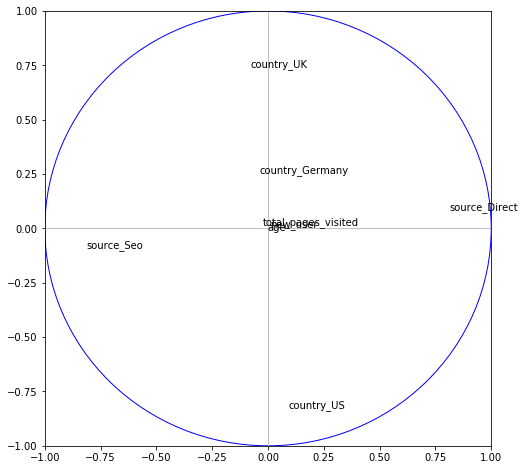

In [114]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(n):
 plt.annotate(X.columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()

## Classification

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=4)

In [116]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [117]:
noms = ['model', 'precision', 'recall', 'accuracy', 'F1-score']
tableau = []

models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(solver='lbfgs'),
},
{
    'label': 'Decision Tree Classifier',
    'model': DecisionTreeClassifier(),
},
{
    'label': 'Random forest Classifier',
    'model': RandomForestClassifier(n_estimators=100),
},
{
    'label': 'GaussianNB',
    'model': GaussianNB(),
}    
]

model                       precision    recall    accuracy    F1-score
------------------------  -----------  --------  ----------  ----------
Logistic Regression          0.85183   0.690326    0.986022    0.762621
Random forest Classifier     0.812139  0.683034    0.984551    0.742012
Decision Tree Classifier     0.820322  0.643656    0.983824    0.721329
GaussianNB                   0.63332   0.763247    0.977925    0.69224


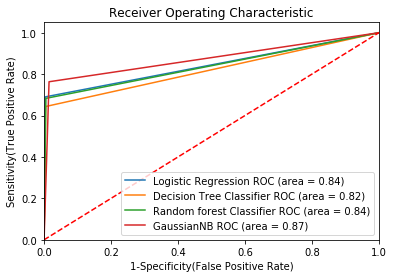

In [118]:
for m in models:
    model = m['model']
    model.fit(X_train, y_train.values.ravel())
    #print(model.score(X_train,y_train))
    #print(model.score(X_test,y_test))
    y_pred = model.predict(X_test)
    scores = []
    scores.append(precision_score(y_test, y_pred))
    scores.append(recall_score(y_test, y_pred))
    scores.append(accuracy_score(y_test, y_pred))
    scores.append(f1_score(y_test, y_pred))
    row = []
    row.append(m['label'])
    for i in range(4):
        row.append(scores[i])
    tableau.append(row)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
    #plot_confusion_matrix(model, X_test, y_test)
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

tableau.sort(key=lambda row: row[-1], reverse=True)
print(tabulate.tabulate(tableau, headers=noms))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display   